# Grad-CAM with ResNet34

In [1]:
import sys
sys.path.append("/Users/msrobin/GitHub Repositorys/Interpretable-Deep-Fake-Detection-2")
sys.argv = ["train.py"]

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

from training.detectors.resnet34_detector import ResnetDetector

# Grid 

In [40]:
class MyToTensor(transforms.ToTensor):
    def __call__(self, input_img):
        if not isinstance(input_img, torch.Tensor):
            return super().__call__(input_img)
        return input_img

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    MyToTensor(),
])

In [41]:
class CustomImageDataset(Dataset):
    def __init__(self, folder_paths, transform=None):
        self.image_files = []
        for fp, label in folder_paths.items():
            self.image_files.extend(
                [(os.path.join(fp, f), label) for f in os.listdir(fp) if f.endswith((".png", ".jpg"))]
            )
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path, label = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label, img_path

In [42]:
file_path_deepfakebench = {
    "/Users/msrobin/GitHub Repositorys/Interpretable-Deep-Fake-Detection-2/datasets/2x2_images": 1
}
dataset = CustomImageDataset(file_path_deepfakebench, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# Not needed anymore?! 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    tensor = transform(image).unsqueeze(0)
    return image, tensor


# Grad Cam

In [36]:
resnet_config = {
    "num_classes": 2,
    "inc": 3,
    "mode": "default",
    "backbone_name": "resnet34",
    "pretrained": "/Users/msrobin/Downloads/bcos_resnet_minimal_b2_ckpt_best.pth",
    "loss_func": "cross_entropy",  
    "backbone_config": {
        "num_classes": 2,
        "inc": 3,
        "mode": "default"
    }
}


In [37]:
model = ResnetDetector(resnet_config)


/opt/anaconda3/envs/lime/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/lime/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Wrap the custom detector so it works with Grad-CAM
class WrappedModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model({"image": x})["cls"]

wrapped_model = WrappedModel(model)

# Use the last conv layer inside resnet34 backbone
target_layers = [model.backbone.resnet[-1][-1].conv2]

cam = GradCAM(model=wrapped_model, target_layers=target_layers)

In [45]:
# Load checkpoint
weights_path = "/Users/msrobin/Downloads/bcos_resnet_minimal_b2_ckpt_best.pth" #Falsche weights ACHTUNG!!
state_dict = torch.load(weights_path, map_location="cpu")
model.load_state_dict(state_dict, strict=False)
model.eval().cuda() if torch.cuda.is_available() else model.eval()


/var/folders/_j/4qb1m8dx3sz3drhj8g_f02qr0000gn/T/ipykernel_50392/2468877681.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_loc

ResnetDetector(
  (backbone): ResNet34(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, e

In [48]:
# Grad-CAM setup
target_layers = [model.backbone.resnet[-1][-1].conv2]  # Last conv layer in layer4
wrapped_model = model

cam = GradCAM(model=wrapped_model, target_layers=target_layers)
targets = [ClassifierOutputTarget(1)]  # Change target class index if needed

# Visualization

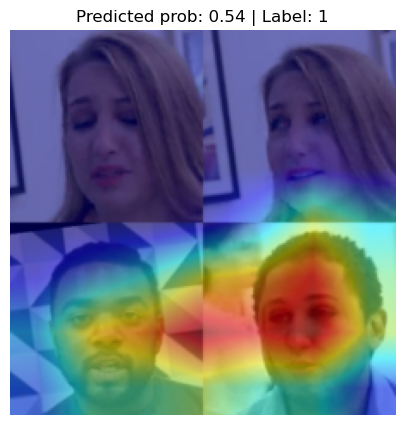

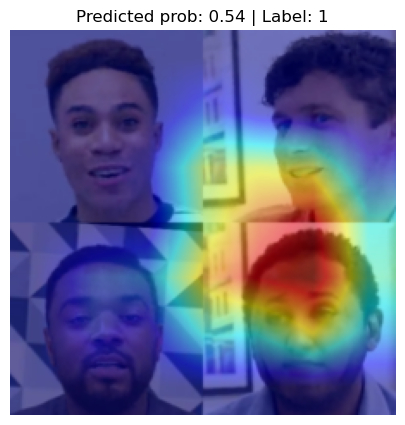

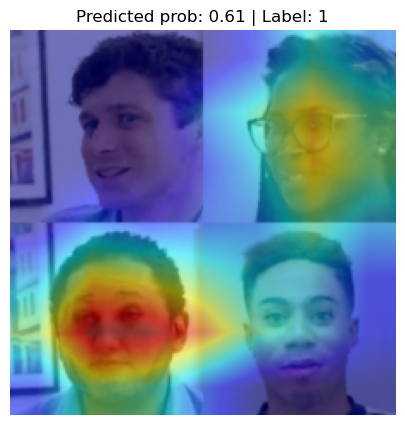

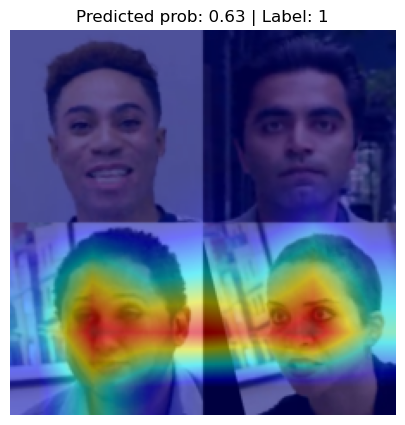

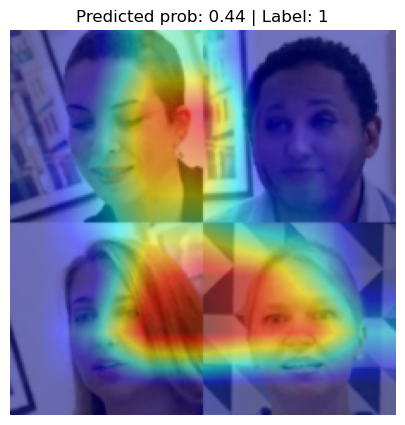

Accuracy: 80.00%


In [47]:
# Initialize counters for accuracy calculation
correct = 0
total = 0

# Start iterating over your DataLoader
for img_batch, label_batch, path_batch in dataloader:
    for i in range(min(5, len(img_batch))):  # Process the first 5 images
        img = img_batch[i].unsqueeze(0).to(device)  # Add batch dimension
        label = label_batch[i].to(device)

        data_dict = {"image": img, "label": label}
        model.zero_grad()
        out = model(data_dict)

        pred_prob = out['prob'].item()
        pred_class = 1 if pred_prob >= 0.5 else 0  # Determine predicted class (fake or real)

        # Accuracy calculation: Compare predicted class with actual label
        if pred_class == label.item():
            correct += 1
        total += 1

        # Grad-CAM generation
        targets = [ClassifierOutputTarget(label.item())]
        grayscale_cam = cam(input_tensor=img, targets=targets)[0]

        img_np = img.squeeze().cpu().numpy().transpose(1, 2, 0)
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # Normalize image
        heatmap = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

        # Display the image with Grad-CAM overlay
        plt.figure(figsize=(10, 5))
        plt.imshow(heatmap)
        plt.axis("off")
        plt.title(f"Predicted prob: {pred_prob:.2f} | Label: {label.item()}")
        plt.show()

# After processing, calculate and display the accuracy
accuracy = correct / total * 100
print(f"Accuracy: {accuracy:.2f}%")